In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU terdeteksi:")
    print(gpus)
else:
    print("GPU tidak terdeteksi")

GPU terdeteksi:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
from enum import Enum
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from keras_unet.utils import plot_segm_history
import keras.backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
# Fungsi untuk menampilkan gambar
def display_images(instances, rows=2, titles=None, figsize=(10, 5)):
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    fig = plt.figure(figsize=figsize)

    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    plt.show()


In [5]:
def one_hot_encode_masks(masks, num_classes):
    integer_encoded_labels = []
    for mask in tqdm(masks):
        _img_height, _img_width, _img_channels = mask.shape
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)
        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j
        integer_encoded_labels.append(encoded_image)
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [6]:
class MaskColorMap(Enum):
    red = (255, 0, 0)
    blue = (0, 0, 255)
    black = (0, 0, 0)

In [7]:
n_classes = len(MaskColorMap)

In [8]:
# Fungsi untuk encode mask RGB
def rgb_encode_mask(mask):
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    for j, cls in enumerate(MaskColorMap):
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

In [9]:
import glob
import cv2 as cv

# Mendapatkan daftar file citra dalam direktori dan mengurutkannya
X = sorted(glob.glob('D:/1_dina/RITE/CLAHE/*.tif'))
Y = sorted(glob.glob('D:/1_dina/RITE/LABEL/*.png'))

In [10]:
x_train = []
for i in range(len(X)):
    x = cv.imread(X[i])
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (512, 512))
    x_train.append(x)

X = np.array(x_train)
len(X)


800

In [11]:
# Prepare the Labels
y_train = []
for i in range(len(Y)):
    y = cv.imread(Y[i])
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    y = cv2.resize(y, (512, 512))
    y_train.append(y)

Y = np.array(y_train)
len(Y)

800

In [12]:
m, img_height, img_width, img_channels = X.shape
X.shape

(800, 512, 512, 3)

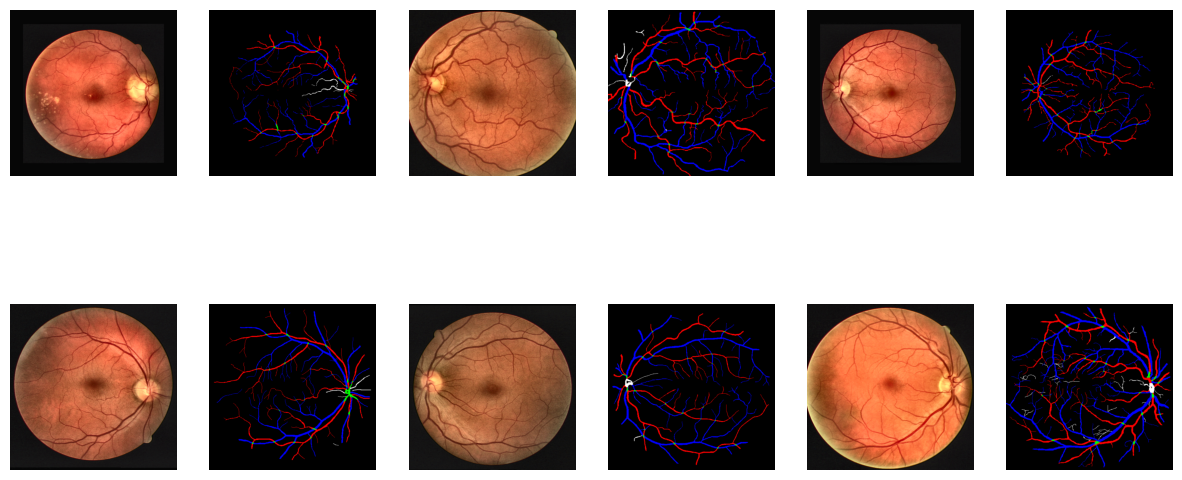

In [13]:
import matplotlib.pyplot as plt

# Set the number of images to display
display_count = 6

# Generate random indices
random_index = [np.random.randint(0, m) for _ in range(display_count)]

# Get the sample images
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]

# Set the number of rows and columns for display
rows = 2
columns = display_count if display_count % 2 == 0 else display_count + 1

# Create a subplot and display images in a larger size
plt.figure(figsize=(15, 7))  # Adjust the figsize to your preferred size
for i, image in enumerate(sample_images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()


In [14]:
from tensorflow.keras.utils import to_categorical

def one_hot_encode_masks(masks, num_classes):
    integer_encoded_labels = []
    for mask in tqdm(masks):
        _img_height, _img_width, _img_channels = mask.shape
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)
        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j
        integer_encoded_labels.append(encoded_image)
    
    # Convert to a numpy array and then one-hot encode
    integer_encoded_labels = np.array(integer_encoded_labels)
    return to_categorical(integer_encoded_labels, num_classes=num_classes)

# Convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# Split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

100%|██████████| 800/800 [00:14<00:00, 53.40it/s]


In [15]:
Y.shape

(800, 512, 512, 3)

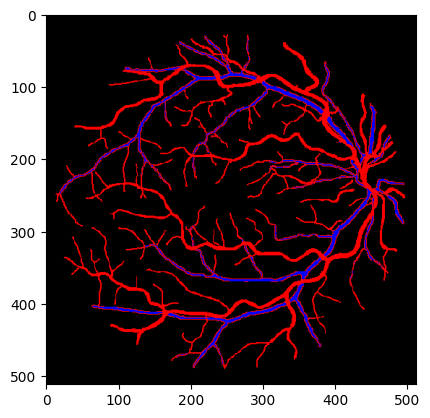

In [16]:
# Warna untuk setiap kelas (merah, hijau, biru, putih, hitam)
colors = [(255, 0, 0), (0, 0, 255), (0, 0, 0)]

# Buat gambar RGB kosong
mask_rgb = np.zeros((512, 512, 3), dtype=np.uint8)

# Iterasi setiap kelas dan tambahkan warna ke gambar RGB
for i, color in enumerate(colors):
    mask_rgb[Y[0][:, :, i] == 1] = color

# Tampilkan mask dalam format RGB
plt.imshow(mask_rgb)
plt.show()


In [17]:
print("X_train shape =",X_train.shape)

X_train shape = (640, 512, 512, 3)


In [18]:
# Fungsi untuk membagi citra menjadi patch
def create_patches(img, patch_size):
    patches = []
    h, w = img.shape[0], img.shape[1]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

In [19]:
def recombine_patches(patches, original_size, patch_size):
    reconstructed_image = np.zeros(original_size)
    num_patches_per_row = original_size[0] // patch_size

    for i in range(num_patches_per_row):
        for j in range(num_patches_per_row):
            patch = patches[i * num_patches_per_row + j]
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch
    
    return reconstructed_image

In [20]:
# Membuat patch dari citra dan mask
patch_size = 128

In [21]:
# Membagi citra dan mask menjadi patch
X_patches = []
Y_patches = []

for img, mask in zip(X_train, Y_train):
    X_patches.extend(create_patches(img, patch_size))
    Y_patches.extend(create_patches(mask, patch_size))

X_patches = np.array(X_patches)
Y_patches = np.array(Y_patches)


In [22]:
import os
from PIL import Image

# Direktori untuk menyimpan patch
x_patches_dir = r"D:\1_dina\patching\image"
y_patches_dir = r"D:\1_dina\patching\label"

# Pastikan direktori sudah ada atau buat jika belum
os.makedirs(x_patches_dir, exist_ok=True)
os.makedirs(y_patches_dir, exist_ok=True)

# Fungsi untuk menyimpan patch
def save_patches(patches, directory, prefix="patch"):
    for i, patch in enumerate(patches):
        # Konversi patch ke format PIL Image
        img = Image.fromarray((patch * 255).astype('uint8'))  # Skala dari [0,1] ke [0,255] jika perlu
        img.save(os.path.join(directory, f"{prefix}_{i}.png"))

# Simpan X_patches dan Y_patches
save_patches(X_patches, x_patches_dir, prefix="X_patch")
save_patches(Y_patches, y_patches_dir, prefix="Y_patch")


Total patches pada X_train: 10240
Total patches pada Y_train: 10240


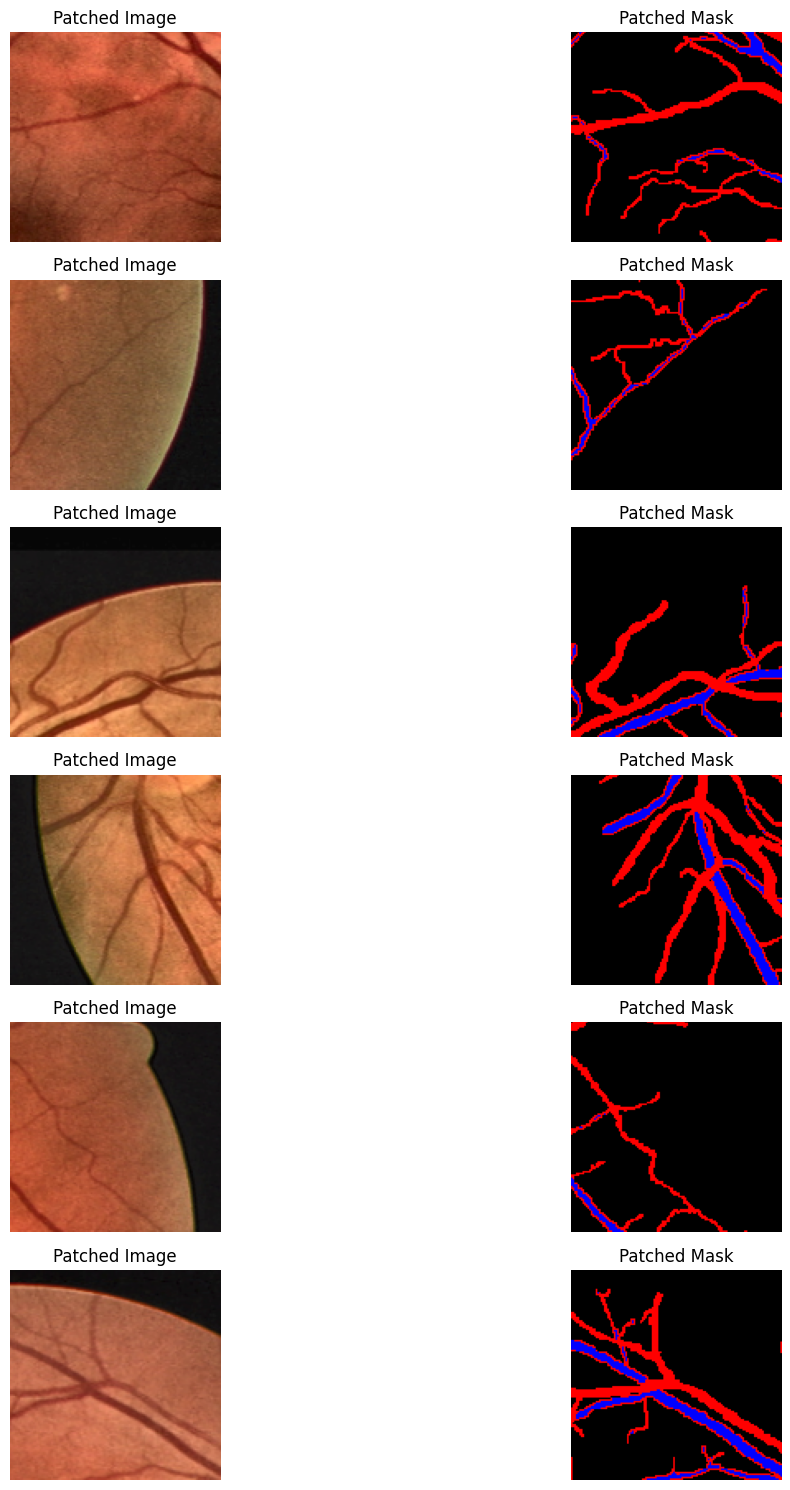

In [23]:
# Function to apply color mapping to the mask
def apply_color_map(mask, color_map):
    color_mask = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    for i, color in enumerate(color_map):
        color_mask[mask == i] = np.array(color.value)
    return color_mask

# Tampilkan jumlah data setelah dipatching
total_patches_X = len(X_patches)
total_patches_Y = len(Y_patches)
print(f"Total patches pada X_train: {total_patches_X}")
print(f"Total patches pada Y_train: {total_patches_Y}")


# Tampilkan beberapa contoh gambar hasil patching dari X_train dan Y_train
num_examples = 6
plt.figure(figsize=(15, 15))

for i in range(num_examples):
    # Ambil contoh gambar dari X_patches secara acak
    rand_idx = np.random.randint(len(X_patches))
    patch_img = X_patches[rand_idx]
    patch_mask = Y_patches[rand_idx]
    
    # Tampilkan gambar hasil patching
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(patch_img)
    plt.title('Patched Image')
    plt.axis('off')
    
    # Gabungkan semua channel mask menjadi satu
    combined_mask = np.argmax(patch_mask, axis=-1)
    colored_mask = apply_color_map(combined_mask, list(MaskColorMap))

    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(colored_mask)
    plt.title('Patched Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Convolution block definition
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
    dropout_rate=0.2,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer='he_normal',
    )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# Dilated Spatial Pyramid Pooling (DSPP)
def DilatedSpatialPyramidPooling(dspp_input, dropout_rate=0.2):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True, dropout_rate=dropout_rate)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, dropout_rate=dropout_rate)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, dropout_rate=dropout_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, dropout_rate=dropout_rate)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, dropout_rate=dropout_rate)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1, dropout_rate=dropout_rate)
    return output

# Attention gate function
def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

# Depthwise Convolution with BN, ReLU, and optional Dropout
def depthwise_bn_relu(x, filters, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', dropout_rate=0.2):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# Deconvolution block
def deconv2d(layer_input, filters, dropout_rate=0.2):
    u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)
    u = convolution_block(u, num_filters=filters, kernel_size=3, dropout_rate=dropout_rate)
    return u

# Main ASPP-Attention U-Net Model with DSPP
def aspp_attention_unet(input_shape, filters=16, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Encoder Block 1
    conv1 = depthwise_bn_relu(inputs, filters * 1, dropout_rate=dropout_rate)
    conv1 = depthwise_bn_relu(conv1, filters * 1, dropout_rate=dropout_rate)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    # Encoder Block 2
    conv2 = depthwise_bn_relu(pool1, filters * 2, dropout_rate=dropout_rate)
    conv2 = depthwise_bn_relu(conv2, filters * 2, dropout_rate=dropout_rate)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    # Encoder Block 3
    conv3 = depthwise_bn_relu(pool2, filters * 4, dropout_rate=dropout_rate)
    conv3 = depthwise_bn_relu(conv3, filters * 4, dropout_rate=dropout_rate)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    # Encoder Block 4
    conv4 = depthwise_bn_relu(pool3, filters * 8, dropout_rate=dropout_rate)
    conv4 = depthwise_bn_relu(conv4, filters * 8, dropout_rate=dropout_rate)
    pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge (Bottleneck) with DSPP
    conv5 = DilatedSpatialPyramidPooling(pool4, dropout_rate=dropout_rate)
    conv5 = depthwise_bn_relu(conv5, filters * 16, dropout_rate=dropout_rate)
    conv5 = depthwise_bn_relu(conv5, filters * 16, dropout_rate=dropout_rate)

    # Decoder Block 1
    up6 = deconv2d(conv5, filters * 8, dropout_rate=dropout_rate)
    attn6 = attention_gate(up6, conv4, filters * 8)
    merge6 = concatenate([attn6, up6], axis=3)

    # Decoder Block 2
    up7 = deconv2d(merge6, filters * 4, dropout_rate=dropout_rate)
    attn7 = attention_gate(up7, conv3, filters * 4)
    merge7 = concatenate([attn7, up7], axis=3)

    # Decoder Block 3
    up8 = deconv2d(merge7, filters * 2, dropout_rate=dropout_rate)
    attn8 = attention_gate(up8, conv2, filters * 2)
    merge8 = concatenate([attn8, up8], axis=3)

    # Decoder Block 4
    up9 = deconv2d(merge8, filters, dropout_rate=dropout_rate)
    attn9 = attention_gate(up9, conv1, filters)
    merge9 = concatenate([attn9, up9], axis=3)

    outputs = Conv2D(3, kernel_size=(1, 1), strides=(1, 1), activation='softmax')(merge9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [25]:
img_shape = (patch_size, patch_size, img_channels)
img_shape

(128, 128, 3)

In [26]:
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

# IoU (Jaccard Index)
def iou_coef(y_true, y_pred):
    y_true_f = K.flatten(K.round(y_true))  # Pastikan dalam bentuk 0/1
    y_pred_f = K.flatten(K.round(y_pred))  # Thresholding 0.5
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return (intersection + K.epsilon()) / (union + K.epsilon())

# Dice Coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(K.round(y_true))
    y_pred_f = K.flatten(K.round(y_pred))
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Recall
def recall_m(y_true, y_pred):
    y_true_f = K.flatten(K.round(y_true))
    y_pred_f = K.flatten(K.round(y_pred))
    
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    
    return true_positives / (possible_positives + K.epsilon())

# Precision
def precision_m(y_true, y_pred):
    y_true_f = K.flatten(K.round(y_true))
    y_pred_f = K.flatten(K.round(y_pred))
    
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)
    
    return true_positives / (predicted_positives + K.epsilon())

# F1 Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [27]:
model = aspp_attention_unet(img_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', iou_coef, recall_m, precision_m, dice_coef, f1_m, rmse])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 depthwise_conv2d (DepthwiseCon  (None, 128, 128, 3)  27         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 3)  12         ['depthwise_conv2d[0][0]']       
 alization)                                                                                   

In [28]:
# datetime for filename saving
model_save_path = "D:/1.dina/model/modell/jurnal21.hdf5"
#csv_logger = rf"{os.getcwd()}/logs2/aerial_segmentation_log_{dt_now}.csv"

In [29]:
# =======================================================
# add callbacks, compile model and fit training data
from tensorflow.keras.callbacks import EarlyStopping
# save best model with maximum validation accuracy
#checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True,
                #mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
#early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1, mode="min")
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0, verbose=1, mode='auto')
# log training console output to csv
#csv_logger = CSVLogger(csv_logger, separator=",", append=False)

# create list of callbacks
#callbacks_list = [checkpoint]  # early_stopping

# train and save model 
history = model.fit(X_patches, Y_patches, epochs=25, batch_size=42, validation_split=0.2)
model.save(model_save_path)
print("model saved:", model_save_path)
                               
# =====================================================

Epoch 1/25
196/196 [==============================] - 53s 200ms/step - loss: 0.4118 - accuracy: 0.8698 - iou_coef: 0.7609 - recall_m: 0.8299 - precision_m: 0.8950 - dice_coef: 0.8593 - f1_m: 0.8593 - rmse: 0.2633 - val_loss: 0.4614 - val_accuracy: 0.8828 - val_iou_coef: 0.7905 - val_recall_m: 0.8829 - val_precision_m: 0.8829 - val_dice_coef: 0.8829 - val_f1_m: 0.8829 - val_rmse: 0.2695
Epoch 2/25
196/196 [==============================] - 35s 180ms/step - loss: 0.2629 - accuracy: 0.9061 - iou_coef: 0.8271 - recall_m: 0.8890 - precision_m: 0.9223 - dice_coef: 0.9053 - f1_m: 0.9053 - rmse: 0.2155 - val_loss: 0.4452 - val_accuracy: 0.8826 - val_iou_coef: 0.7906 - val_recall_m: 0.8817 - val_precision_m: 0.8842 - val_dice_coef: 0.8830 - val_f1_m: 0.8830 - val_rmse: 0.2647
Epoch 3/25
196/196 [==============================] - 36s 183ms/step - loss: 0.2320 - accuracy: 0.9138 - iou_coef: 0.8403 - recall_m: 0.9016 - precision_m: 0.9251 - dice_coef: 0.9132 - f1_m: 0.9132 - rmse: 0.2046 - val_los

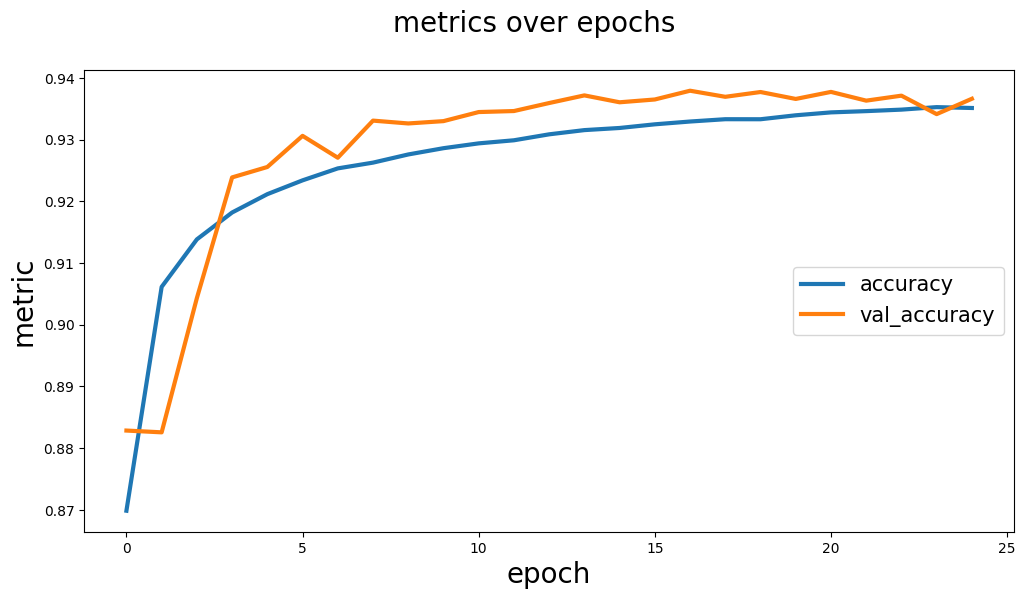

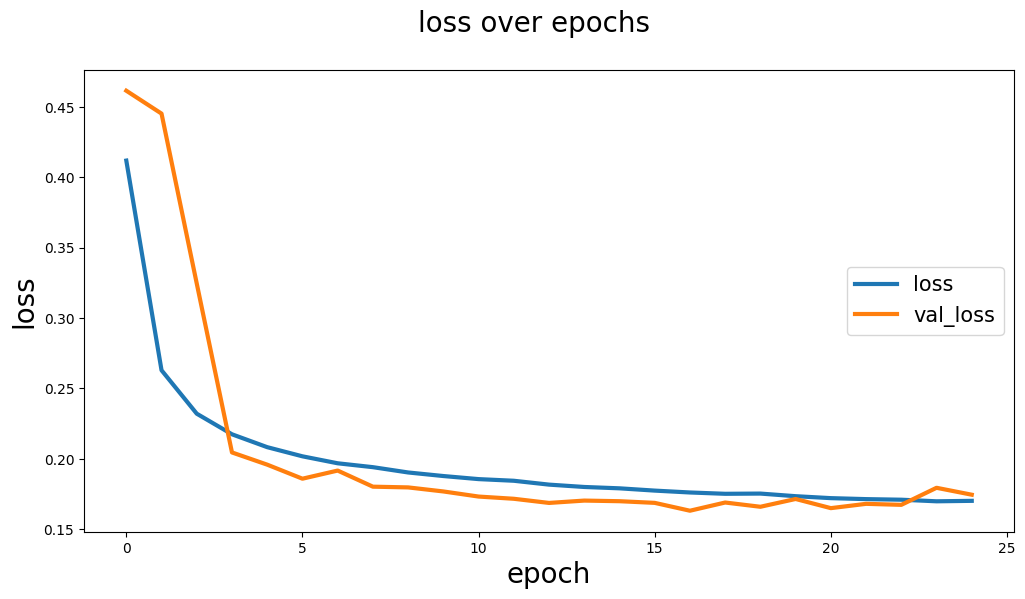

In [30]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['accuracy', 'val_accuracy'],
    losses=['loss', 'val_loss']
)
plt.show()

1/1 [==============================] - 0s 23ms/step


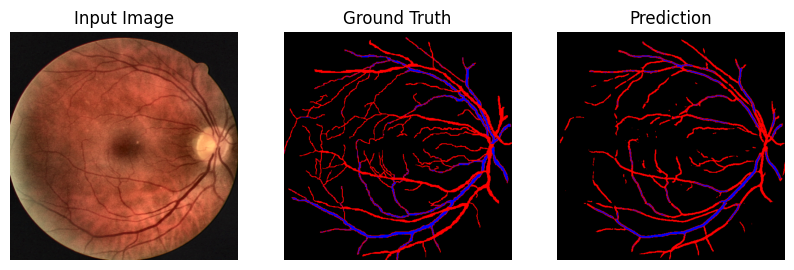

Saved: D:/1.dina/model/gambar hasil1/prediction_0.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_0.png
1/1 [==============================] - 0s 22ms/step


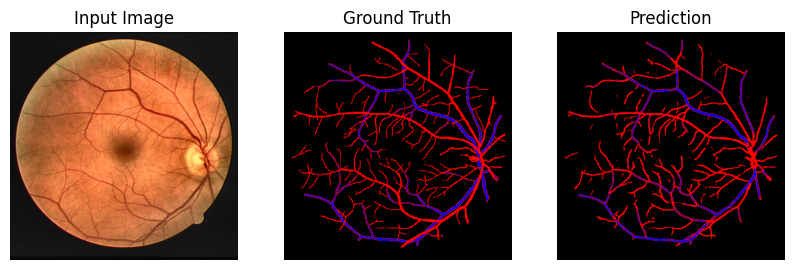

Saved: D:/1.dina/model/gambar hasil1/prediction_1.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_1.png
1/1 [==============================] - 0s 25ms/step


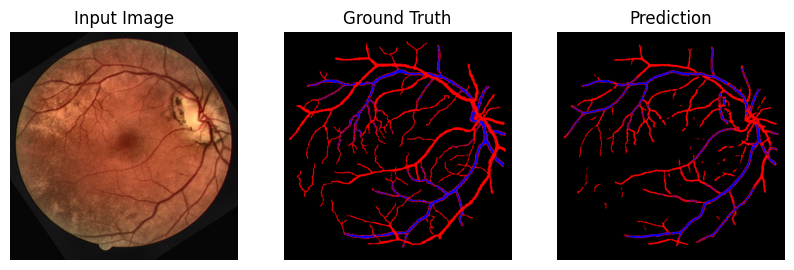

Saved: D:/1.dina/model/gambar hasil1/prediction_2.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_2.png
1/1 [==============================] - 0s 22ms/step


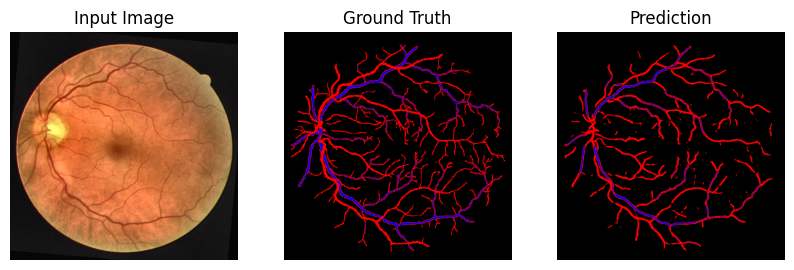

Saved: D:/1.dina/model/gambar hasil1/prediction_3.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_3.png
1/1 [==============================] - 0s 23ms/step


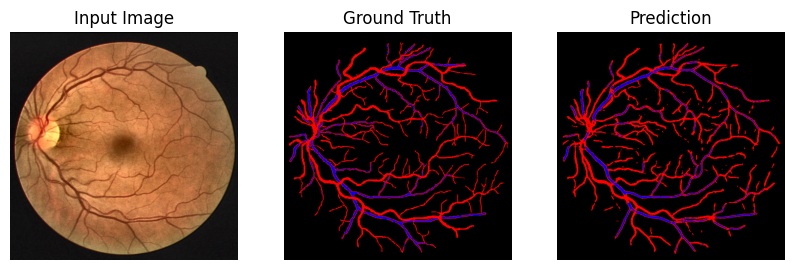

Saved: D:/1.dina/model/gambar hasil1/prediction_4.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_4.png
1/1 [==============================] - 0s 21ms/step


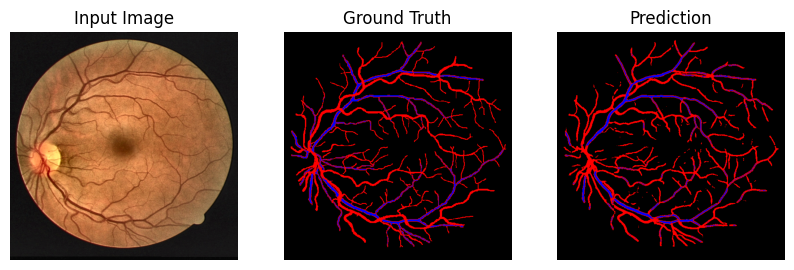

Saved: D:/1.dina/model/gambar hasil1/prediction_5.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_5.png
1/1 [==============================] - 0s 26ms/step


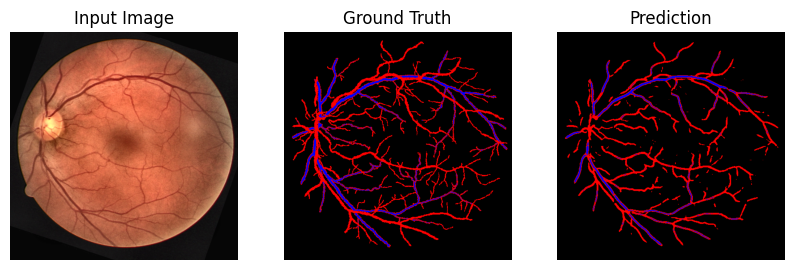

Saved: D:/1.dina/model/gambar hasil1/prediction_6.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_6.png
1/1 [==============================] - 0s 22ms/step


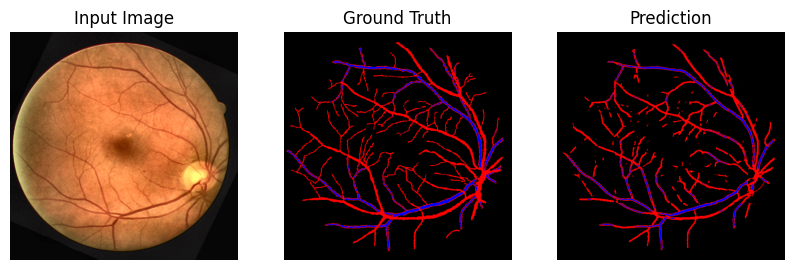

Saved: D:/1.dina/model/gambar hasil1/prediction_7.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_7.png
1/1 [==============================] - 0s 22ms/step


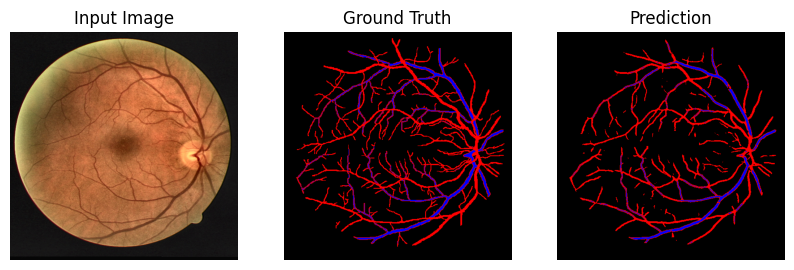

Saved: D:/1.dina/model/gambar hasil1/prediction_8.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_8.png
1/1 [==============================] - 0s 23ms/step


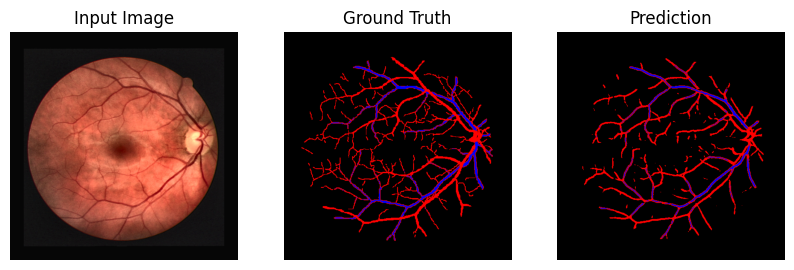

Saved: D:/1.dina/model/gambar hasil1/prediction_9.png
Saved: D:/1.dina/model/gambar hasil1/ground_truth_9.png


In [31]:
# Fungsi untuk menyimpan gambar
def save_image(image, path, file_name):
    image_path = os.path.join(path, file_name)
    image.save(image_path)
    print(f"Saved: {image_path}")

# Pastikan direktori hasil sudah ada, jika belum buat direktori
output_dir = "D:/1.dina/model/gambar hasil1/"
#D:\\1_dina\\TA\\gambar hasil
#D:/1.dina/model/gambar hasil
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(10):
    test_img_number = np.random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    test_patches = create_patches(test_img, patch_size)
    
    predictions = []
    for patch in test_patches:
        patch_input = np.expand_dims(patch, 0)
        prediction = model.predict(patch_input)
        predictions.append(np.squeeze(prediction))
    
    predictions = np.array(predictions)
    reconstructed_prediction = recombine_patches(predictions, (512, 512, 3), patch_size)
    predicted_img = np.argmax(reconstructed_prediction, axis=-1)
    rgb_image = rgb_encode_mask(predicted_img)
    
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # Visualisasi hasil prediksi model
    display_images(
        [test_img, rgb_ground_truth, rgb_image],
        rows=1, titles=['Input Image', 'Ground Truth', 'Prediction']
    )
    
    # Simpan hasil prediksi
    prediction_image = Image.fromarray((rgb_image * 255).astype(np.uint8))  # Konversi ke Image dan uint8
    ground_truth_image = Image.fromarray((rgb_ground_truth * 255).astype(np.uint8))

    save_image(prediction_image, output_dir, f"prediction_{i}.png")
    save_image(ground_truth_image, output_dir, f"ground_truth_{i}.png")

In [32]:
# Load model
#D:/1.dina/model/modell/model-1.hdf5"
model_dir = 'D:/1.dina/model/modell/'
model_name = 'jurnal21.hdf5'

In [33]:
from tensorflow.keras.models import load_model
model = load_model(model_dir + model_name, custom_objects={'iou_coef':iou_coef,'recall_m':recall_m,
                                                           'precision_m':precision_m,'f1_m':f1_m,
                                                           'dice_coef':dice_coef,'rmse':rmse})

In [34]:
from sklearn.metrics import confusion_matrix, classification_report,roc_curve

In [35]:
# Memuat model yang sudah dilatih
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Membuat patch dari citra uji untuk prediksi
test_img_patches = []
patch_size = 128  # Misalnya ukuran patch, sesuaikan jika perlu
for img in X_test:
    test_img_patches.extend(create_patches(img, patch_size))  # Pastikan create_patches berfungsi dengan baik
test_img_patches = np.array(test_img_patches)

# Melakukan prediksi pada patch citra uji
predictions = model.predict(test_img_patches)

# Rekonstruksi citra dari patch
reconstructed_preds = []
for i in range(len(X_test)):
    start_idx = i * (512 // patch_size) ** 2
    end_idx = (i + 1) * (512 // patch_size) ** 2
    reconstructed_pred = recombine_patches(predictions[start_idx:end_idx], (512, 512, 3), patch_size)
    reconstructed_preds.append(reconstructed_pred)

# Mengubah probabilitas softmax menjadi label integer
pred = [np.argmax(rp, axis=-1) for rp in reconstructed_preds]  # Mengambil prediksi kelas
pred = np.array(pred)

# Mengubah Y_test (label asli) dari one-hot encoding menjadi label integer
Y_test1 = np.argmax(Y_test, axis=3)

# Meratakan (flatten) array untuk confusion matrix
pred = pred.flatten()
Y_test1 = Y_test1.flatten()

# Menghitung confusion matrix
cm = confusion_matrix(Y_test1, pred)
print("Confusion Matrix:")
print(cm)

# Menampilkan classification report
report = classification_report(Y_test1, pred, digits=4)
print("Classification Report:")
print(report)

80/80 [==============================] - 3s 30ms/step
Confusion Matrix:
[[ 2323088   245383  1267065]
 [  449922   596082    43500]
 [  617311     6080 36394609]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6852    0.6057    0.6430   3835536
           1     0.7033    0.5471    0.6155   1089504
           2     0.9652    0.9832    0.9741  37018000

    accuracy                         0.9373  41943040
   macro avg     0.7846    0.7120    0.7442  41943040
weighted avg     0.9328    0.9373    0.9345  41943040



In [36]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_iou(cm):
    ious = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True Positives untuk kelas i
        fp = cm[:, i].sum() - tp  # False Positives untuk kelas i
        fn = cm[i, :].sum() - tp  # False Negatives untuk kelas i
        denom = tp + fp + fn
        if denom == 0:
            iou = 0.0  # Jika tidak ada prediksi untuk kelas ini
        else:
            iou = tp / denom
        ious.append(iou)
    return ious

# Menghitung IoU per kelas
ious = calculate_iou(cm)
for i, iou in enumerate(ious):
    print(f"IoU untuk kelas {i}: {iou:.4f}")
# Menghitung rata-rata Dice Coefficient (macro-average dice)
average_iou = np.mean(ious)
print(f"Rata-rata IoU Coefficient: {average_iou:.4f}")

IoU untuk kelas 0: 0.4738
IoU untuk kelas 1: 0.4445
IoU untuk kelas 2: 0.9495
Rata-rata IoU Coefficient: 0.6226


In [37]:
def calculate_dice(cm):
    dice_scores = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True Positives untuk kelas i
        fp = cm[:, i].sum() - tp  # False Positives untuk kelas i
        fn = cm[i, :].sum() - tp  # False Negatives untuk kelas i
        denom = (2 * tp) + fp + fn
        if denom == 0:
            dice = 0.0  # Jika tidak ada prediksi untuk kelas ini
        else:
            dice = 2 * tp / denom
        dice_scores.append(dice)
    return dice_scores


# Menghitung Dice Coefficient per kelas
dice_scores = calculate_dice(cm)
for i, dice in enumerate(dice_scores):
    print(f"Dice Coefficient untuk kelas {i}: {dice:.4f}")
# Menghitung rata-rata Dice Coefficient (macro-average dice)
average_dice = np.mean(dice_scores)
print(f"Rata-rata Dice Coefficient: {average_dice:.4f}")

Dice Coefficient untuk kelas 0: 0.6430
Dice Coefficient untuk kelas 1: 0.6155
Dice Coefficient untuk kelas 2: 0.9741
Rata-rata Dice Coefficient: 0.7442


In [38]:
def calculate_sensitivity(cm):
    sensitivities = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True Positives untuk kelas i
        fn = cm[i, :].sum() - tp  # False Negatives untuk kelas i
        denom = tp + fn
        if denom == 0:
            sensitivity = 0.0  # Jika tidak ada positif sejati
        else:
            sensitivity = tp / denom
        sensitivities.append(sensitivity)
    return sensitivities

# Menghitung Sensitivitas (Recall) per kelas
sensitivities = calculate_sensitivity(cm)
for i, sensitivity in enumerate(sensitivities):
    print(f"Sensitivitas (Recall) untuk kelas {i}: {sensitivity:.4f}")

# Menghitung rata-rata sensitivitas (macro-average recall)
average_sensitivity = np.mean(sensitivities)
print(f"Rata-rata Sensitivitas (Recall): {average_sensitivity:.4f}")

Sensitivitas (Recall) untuk kelas 0: 0.6057
Sensitivitas (Recall) untuk kelas 1: 0.5471
Sensitivitas (Recall) untuk kelas 2: 0.9832
Rata-rata Sensitivitas (Recall): 0.7120


In [39]:
def calculate_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True Positives untuk kelas i
        fp = cm[:, i].sum() - tp  # False Positives untuk kelas i
        fn = cm[i, :].sum() - tp  # False Negatives untuk kelas i
        tn = cm.sum() - (tp + fp + fn)  # True Negatives untuk kelas i
        
        denom = tn + fp
        if denom == 0:
            specificity = 0.0  # Jika tidak ada negatif
        else:
            specificity = tn / denom
        specificities.append(specificity)
    return specificities


# Menghitung Spesifisitas (TNR) per kelas
specificities = calculate_specificity(cm)
for i, specificity in enumerate(specificities):
    print(f"Spesifisitas (TNR) untuk kelas {i}: {specificity:.4f}")

# Menghitung rata-rata spesifisitas (macro-average specificity)
average_specificity = np.mean(specificities)
print(f"Rata-rata Spesifisitas (TNR): {average_specificity:.4f}")


Spesifisitas (TNR) untuk kelas 0: 0.9720
Spesifisitas (TNR) untuk kelas 1: 0.9938
Spesifisitas (TNR) untuk kelas 2: 0.7339
Rata-rata Spesifisitas (TNR): 0.8999


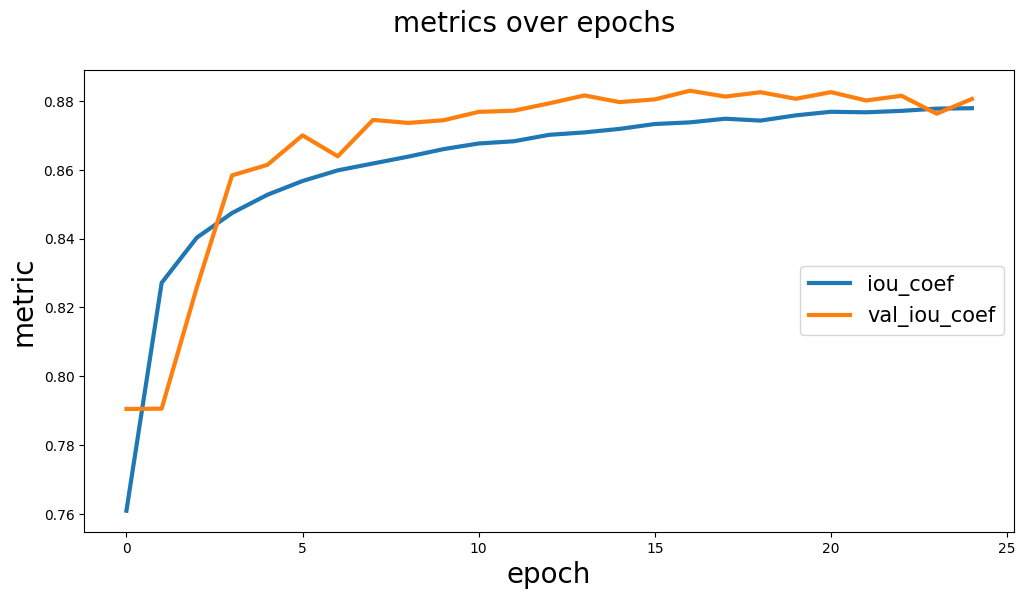

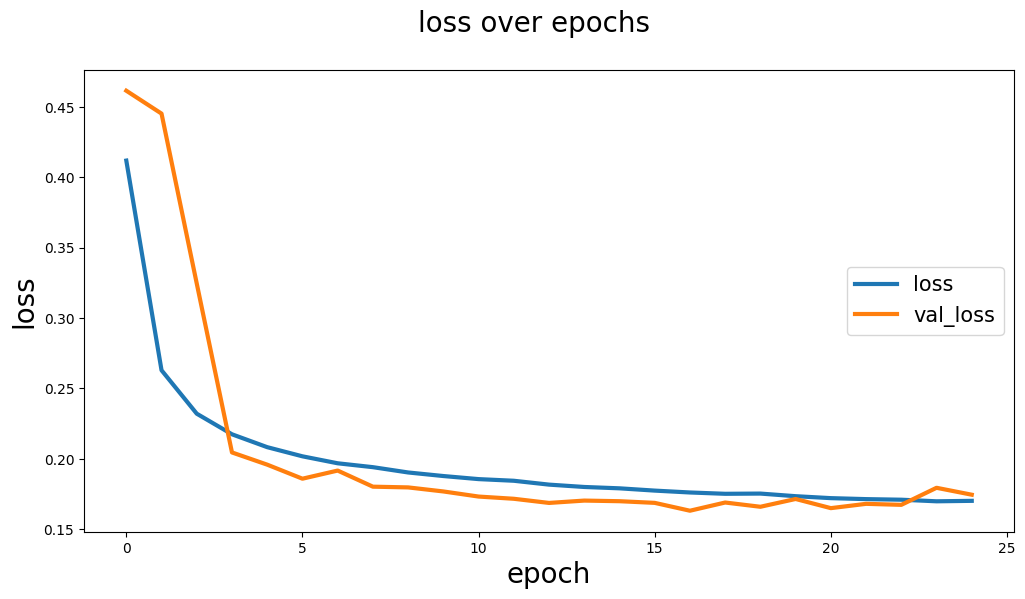

In [40]:
from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['iou_coef', 'val_iou_coef']
)


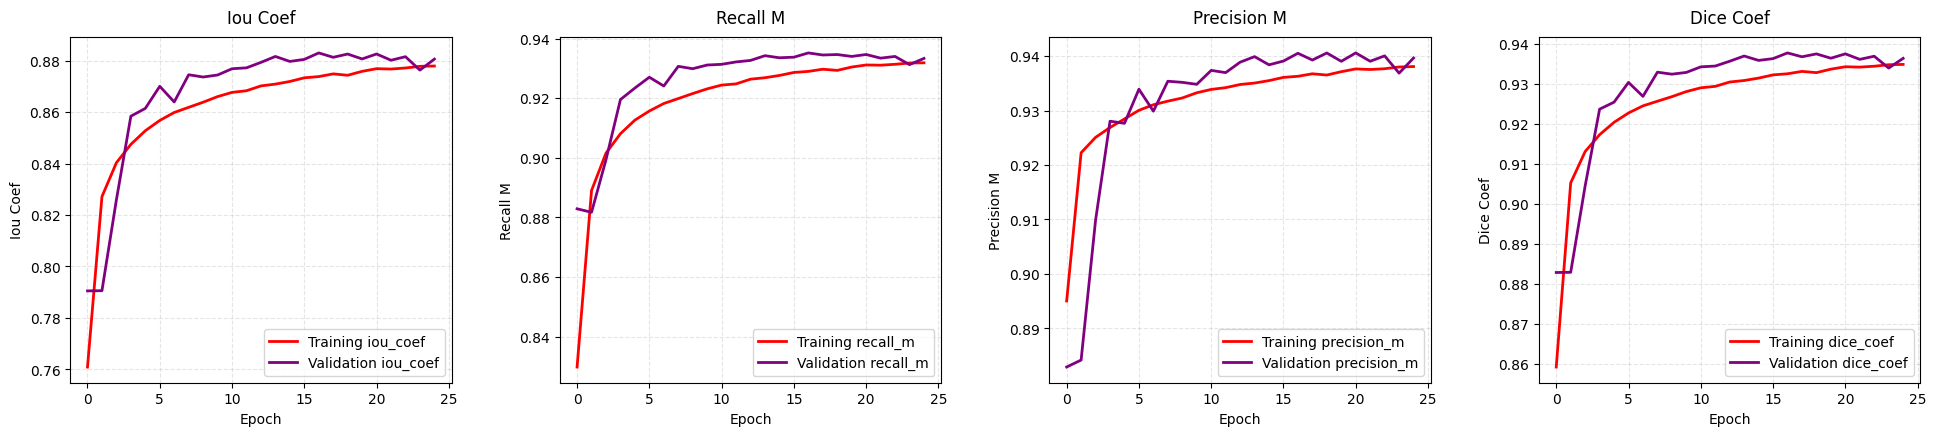

<Figure size 640x480 with 0 Axes>

In [41]:
# Load model terbaik
model = load_model(model_dir + model_name, custom_objects={'iou_coef':iou_coef,'recall_m':recall_m,
                                                           'precision_m':precision_m,'f1_m':f1_m,
                                                           'dice_coef':dice_coef,'rmse':rmse})

# Visualisasi semua metrics
metrics = [ 'iou_coef', 'recall_m', 'precision_m', 
          'dice_coef']

# Membuat subplot grid
n_metrics = len(metrics)
n_cols = 4  # 4 kolom
n_rows = (n_metrics + n_cols - 1) // n_cols  # Menghitung jumlah baris yang diperlukan

plt.figure(figsize=(20, 5*n_rows))

for i, metric in enumerate(metrics):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Plot dengan warna yang ditentukan
    plt.plot(history.history[metric], 
             label=f'Training {metric}', 
             color='red',
             linewidth=2)
    plt.plot(history.history[f'val_{metric}'], 
             label=f'Validation {metric}', 
             color='purple',
             linewidth=2)
    
    # Menambahkan grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Styling plot
    plt.title(f'{metric.replace("_", " ").title()}', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=10)
    plt.legend(loc='best', fontsize=10)
    
    # Mengatur background grid di belakang plot
    plt.gca().set_axisbelow(True)
    
    # Mengatur warna background grid
    plt.gca().grid(color='gray', linestyle='--', alpha=0.2)

plt.tight_layout(pad=3.0)  # Menambah padding antar subplot
plt.show()

# Menyimpan plot
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

In [42]:
def calculate_metrics(y_true, y_pred):
    # Thresholding y_pred agar 0 atau 1
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)
    
    # Flatten untuk perhitungan confusion matrix
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_bin.flatten()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_f, y_pred_f)
    
    # Menghitung IoU untuk setiap kelas
    def calculate_iou(cm):
        ious = []
        for i in range(len(cm)):
            tp = cm[i, i]  # True Positives
            fp = cm[:, i].sum() - tp  # False Positives
            fn = cm[i, :].sum() - tp  # False Negatives
            denom = tp + fp + fn
            iou = tp / denom if denom > 0 else 0.0
            ious.append(iou)
        return ious
    
    ious = calculate_iou(cm)
    mean_iou = np.mean(ious)
    
    # Menghitung Dice Coefficient
    dice_scores = [2 * cm[i, i] / (cm[i, :].sum() + cm[:, i].sum()) if cm[i, :].sum() + cm[:, i].sum() > 0 else 0 for i in range(len(cm))]
    mean_dice = np.mean(dice_scores)
    
    print(f"Confusion Matrix:\n{cm}")
    for i, iou in enumerate(ious):
        print(f"IoU untuk kelas {i}: {iou:.4f}")
    print(f"Rata-rata IoU: {mean_iou:.4f}")
    print(f"Rata-rata Dice Coefficient: {mean_dice:.4f}")

    return mean_iou, mean_dice